### Домашнее задание № 5



In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [4]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

наблюдается небольшой дисбаланс

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

Категориальные признаки закодируем с помощью OneHotEncoding

Вещественные оставим пока как есть


In [6]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [7]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [8]:
# списки признаков

categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [9]:
# Обработаем признак Gender

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле)

In [10]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [11]:
final_transformers[:2]

[('Geography',
  Pipeline(steps=[('selector', FeatureSelector(column='Geography')),
                  ('ohe', OHEEncoder(key='Geography'))])),
 ('Gender',
  Pipeline(steps=[('selector', FeatureSelector(column='Gender')),
                  ('ohe', OHEEncoder(key='Gender'))]))]

Объединим все это в единый пайплайн

In [12]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

#### Задание 1. 
Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
Реализуем разные модели

1) Случайный лес

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, confusion_matrix, average_precision_score,\
auc, plot_confusion_matrix

In [15]:
models={
    'model': [],
    'f_score':[],
    'roc_auc':[],
    'pr_auc':[],
    'TP':[],
    'FP':[],
    'FN':[],
    'TN':[]
}

In [16]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

В связи с дисбалансом классов используем в качестве метрики также PR кривую

In [18]:
# Создадим функцию, которая будет выводить результаты предсказания
# В качестве метрик возьмем fscore, rocauc и pr кривую

def evaluate_model(pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict_proba(X_test)[:,1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, preds)

    fscore = (2 * precision * recall) / (precision + recall)
    
    ix = np.argmax(fscore)
    best_fscore = fscore[ix]
    rocauc = roc_auc_score(y_test, preds)
    pr_auc = auc(recall, precision)
    cm = confusion_matrix(y_test, preds>thresholds[ix])
    
    print(f'model: {pipeline["classifier"]}, \nfscore: {best_fscore:.3f}, \nROC AUC: {rocauc:.3f},\
    \nPR_AUC: {pr_auc:.3f}, \nconfusion_matrix: \n{cm}')
    
    return best_fscore, rocauc, pr_auc, cm

In [19]:
rf_pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [20]:
rf_best_fscore, rf_rocauc, rf_pr_auc, rf_cm = evaluate_model(rf_pipeline, X_train, y_train, X_test, y_test)

model: RandomForestClassifier(random_state=42), 
fscore: 0.641, 
ROC AUC: 0.864,    
PR_AUC: 0.698, 
confusion_matrix: 
[[1832  159]
 [ 195  314]]


In [21]:
models['model'].append('Random Forest')
models['f_score'].append(rf_best_fscore)
models['roc_auc'].append(rf_rocauc)
models['pr_auc'].append(rf_pr_auc)
models['TP'].append(rf_cm[0,0])
models['FP'].append(rf_cm[0,1])
models['FN'].append(rf_cm[1,0])
models['TN'].append(rf_cm[1,1])

2) Градиентный бустинг

In [22]:
gb_pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

In [23]:
gb_best_fscore, gb_rocauc, gb_pr_auc, gb_cm = evaluate_model(gb_pipeline, X_train, y_train, X_test, y_test)


model: GradientBoostingClassifier(random_state=42), 
fscore: 0.646, 
ROC AUC: 0.876,    
PR_AUC: 0.724, 
confusion_matrix: 
[[1863  128]
 [ 206  303]]


In [24]:
models['model'].append('Gradient Boosting')
models['f_score'].append(gb_best_fscore)
models['roc_auc'].append(gb_rocauc)
models['pr_auc'].append(gb_pr_auc)
models['TP'].append(gb_cm[0,0])
models['FP'].append(gb_cm[0,1])
models['FN'].append(gb_cm[1,0])
models['TN'].append(gb_cm[1,1])

3) Логистическая регрессия

In [25]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
X_train.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2967,2968,15595324,Daniels,579,Germany,Female,39,5,117833.30,3,0,0,5831.00,1
700,701,15803457,Hao,750,France,Female,32,5,0.00,2,1,0,95611.47,0
3481,3482,15644686,Kennedy,729,Spain,Female,34,9,53299.96,2,1,1,42855.97,0


In [27]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', MinMaxScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [28]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [29]:
lr_pipeline = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state = 1))
])

In [30]:
lr_best_fscore, lr_rocauc, lr_pr_auc, lr_cm = evaluate_model(lr_pipeline, X_train, y_train, X_test, y_test)

model: LogisticRegression(random_state=1), 
fscore: 0.509, 
ROC AUC: 0.771,    
PR_AUC: 0.476, 
confusion_matrix: 
[[1650  341]
 [ 220  289]]


In [31]:
models['model'].append('Logistic Regression')
models['f_score'].append(lr_best_fscore)
models['roc_auc'].append(lr_rocauc)
models['pr_auc'].append(lr_pr_auc)
models['TP'].append(lr_cm[0,0])
models['FP'].append(lr_cm[0,1])
models['FN'].append(lr_cm[1,0])
models['TN'].append(lr_cm[1,1])

#### Задание 2. 
Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

In [32]:
models = pd.DataFrame(models)
models

,model,f_score,roc_auc,pr_auc,TP,FP,FN,TN
0,Random Forest,0.640641,0.863502,0.698049,1832,159,195,314
1,Gradient Boosting,0.646121,0.875746,0.724044,1863,128,206,303
2,Logistic Regression,0.508772,0.771223,0.475987,1650,341,220,289


<b>Вывод: </b>В большей степени обращаем внимание на показатели<b> fscore, PR_AUC, FP, FN</b>

Наилучшие результаты в совокупности метрик дает модель Градиентного бустинга:

Наименьшее значение FP сэкономит "ненужные" затраты на возвращение клиента, показатель FN также минимален, то есть из всех моделей, с этой мы пропустим наименьшее количество клиентов, которые уходят "в отток".

Остальные показатели также выше остальных моделей

#### Задание 3. 
Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

In [33]:
y_pred = gb_pipeline.predict_proba(X_test)[:,1]

In [34]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
fscore =  (2*precision * recall) / (precision + recall)

ix = np.argmax(fscore)
best_threshold = thresholds[ix]

In [35]:
cm = confusion_matrix(y_test, y_pred > thresholds[ix])
cm

array([[1863,  128],
       [ 206,  303]], dtype=int64)

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


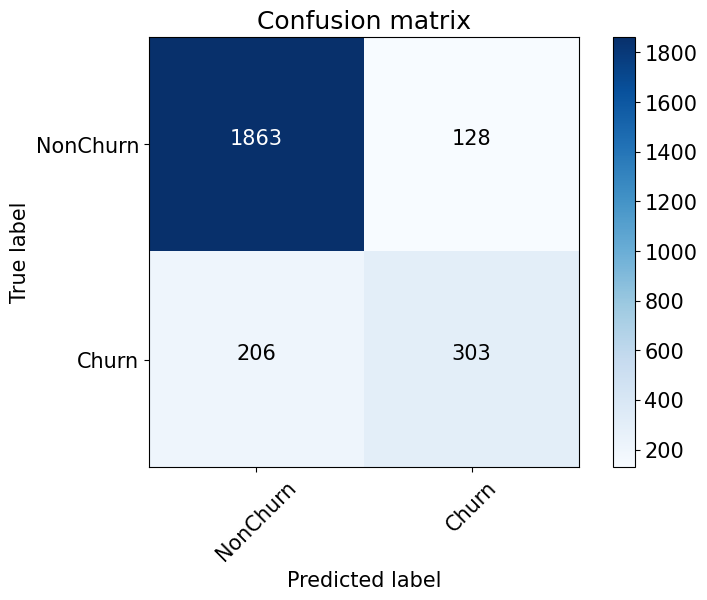

In [37]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.show()

In [38]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

#### Условие задачи:
    
1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного

In [39]:
def calc_economic_effect(cm):
    
    # Доходы от правильно классифицированных клиентов "оттока"
    tp_revenue = cm[1,1]*2
    
    # расходы на удержание
    costs = sum(cm[:,1])*1

    # Расчитаем разницу между прибыль и использованием модели и без
    economic_effect = tp_revenue - costs
    
    print(economic_effect)
    return economic_effect

In [40]:
cm = confusion_matrix(y_test, y_pred>thresholds[ix])


ec_effect = calc_economic_effect(cm)
print(f"порог: {thresholds[ix]}, \nприбыль: {ec_effect} долл.")

175
порог: 0.4085078904556646, 
прибыль: 175 долл.


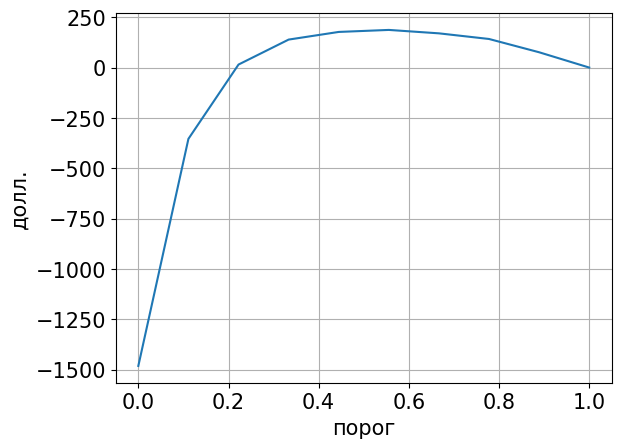

In [41]:
#  Изучим влияние threshold на наш экономический эффект
ec_effect =[]

trh_level = np.linspace(0,1,10).tolist()
for trh in trh_level:
    cm = confusion_matrix(y_test, y_pred>trh)
    ec_effect.append(cm[1,1]*2-sum(cm[:,1])*1)
    
plt.plot(trh_level, ec_effect)
plt.ylabel('долл.')
plt.xlabel('порог')
plt.grid()
plt.show()

По графике видно, что максимум прибыли достигается где-то между 0.4 и 0.6, значение порога по f-score получился 0.408 

Подберем максимально точный порог, опираясь уже на величину прибыли economic_effect

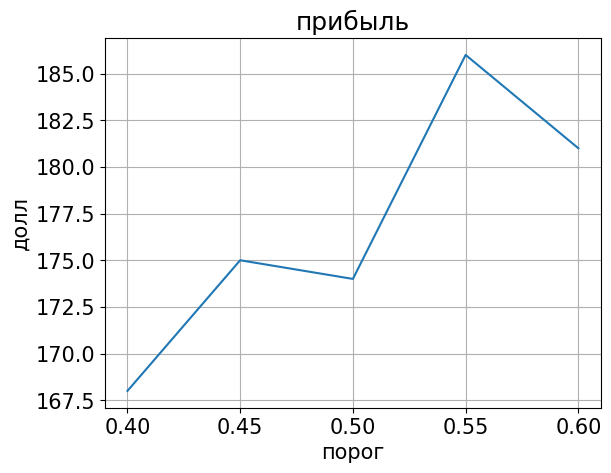

In [42]:
ec_effect =[]
trh_level = np.linspace(0.4,0.6,5).tolist()
for trh in trh_level:
    cm = confusion_matrix(y_test, y_pred >trh)
    ec_effect.append(cm[1,1]*2-sum(cm[:,1])*1)

plt.plot(trh_level, ec_effect)
plt.ylabel('долл')
plt.xlabel('порог')
plt.title('прибыль')
plt.grid()
plt.show()


Можно утверждать, что максимальное значение прибыли мы достигнем при пороге 1 класса = 0.550

Проверим

In [43]:
thr = 0.55
cm = confusion_matrix(y_test, y_pred>thr)


ec_effect = calc_economic_effect(cm)
print(f"порог: {thr}, \nприбыль: {ec_effect} долл")


186
порог: 0.55, 
прибыль: 186 долл


### Вывод:
Модель целесообразна к использованию.